In [86]:
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)

model, tokenizer = get_default_model_and_tokenizer()

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

example_rxn = "Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1"

fp = rxnfp_generator.convert(example_rxn)
print(len(fp))
print(fp[:5])

256
[-2.017495632171631, 1.7602040767669678, -1.3323537111282349, -1.1095024347305298, 1.2254549264907837]


In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
#hide
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

In [89]:
import collections
import logging
import os
import re
import numpy as np
from rdkit import Chem

import pkg_resources

from typing import List

from transformers import BertTokenizer

In [90]:
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def get_default_tokenizer():
    default_vocab_path = (
        pkg_resources.resource_filename(
                    "rxnfp",
                    "models/transformers/bert_ft_10k_25s/vocab.txt"
                )
    )
    return SmilesTokenizer(default_vocab_path, do_lower_case=False)


class SmilesTokenizer(BertTokenizer):
    """
    Constructs a SmilesBertTokenizer.
    Adapted from https://github.com/huggingface/transformers
    and https://github.com/rxn4chemistry/rxnfp.
    
    Args:
        vocabulary_file: path to a token per line vocabulary file.
    """

    def __init__(
        self,
        vocab_file: str,
        unk_token: str = "[UNK]",
        sep_token: str = "[SEP]",
        pad_token: str = "[PAD]",
        cls_token: str = "[CLS]",
        mask_token: str = "[MASK]",
        do_lower_case=False,
        **kwargs,
    ) -> None:
        """Constructs an SmilesTokenizer.
        Args:
            vocabulary_file: vocabulary file containing tokens.
            unk_token: unknown token. Defaults to "[UNK]".
            sep_token: separator token. Defaults to "[SEP]".
            pad_token: pad token. Defaults to "[PAD]".
            cls_token: cls token. Defaults to "[CLS]".
            mask_token: mask token. Defaults to "[MASK]".
        """
        super().__init__(
            vocab_file=vocab_file,
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            do_lower_case=do_lower_case,
            **kwargs,
        )
        # define tokenization utilities
        self.tokenizer = RegexTokenizer()

    @property
    def vocab_list(self) -> List[str]:
        """List vocabulary tokens.
        Returns:
            a list of vocabulary tokens.
        """
        return list(self.vocab.keys())

    def _tokenize(self, text: str) -> List[str]:
        """Tokenize a text representing an enzymatic reaction with AA sequence information.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens.
        """
        return self.tokenizer.tokenize(text)


class RegexTokenizer:
    """Run regex tokenization"""

    def __init__(self, regex_pattern: str=SMI_REGEX_PATTERN) -> None:
        """Constructs a RegexTokenizer.
        Args:
            regex_pattern: regex pattern used for tokenization.
            suffix: optional suffix for the tokens. Defaults to "".
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text: str) -> List[str]:
        """Regex tokenization.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens separated by spaces.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens

In [91]:
#export
class NotCanonicalizableSmilesException(ValueError):
    pass


def canonicalize_smi(smi, remove_atom_mapping=False):
    r"""
    Canonicalize SMILES
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        raise NotCanonicalizableSmilesException("Molecule not canonicalizable")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)


def process_reaction(rxn):
    """
    Process and canonicalize reaction SMILES 
    """
    reactants, reagents, products = rxn.split(">")
    try:
        precursors = [canonicalize_smi(r, True) for r in reactants.split(".")]
        if len(reagents) > 0:
            precursors += [
                canonicalize_smi(r, True) for r in reagents.split(".")
            ]
        products = [canonicalize_smi(p, True) for p in products.split(".")]
    except NotCanonicalizableSmilesException:
        return ""

    joined_precursors = ".".join(sorted(precursors))
    joined_products = ".".join(sorted(products))
    return f"{joined_precursors}>>{joined_products}"

In [92]:
atom_mapped_rxn = 'F[c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11].[CH3:1][CH:2]([CH3:3])[SH:4]>CN(C)C=O.O=C([O-])[O-].[K+].[K+]>[CH3:1][CH:2]([CH3:3])[S:4][c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11]'
canonical_rxn = "CC(C)S.CN(C)C=O.Fc1cccnc1F.O=C([O-])[O-].[K+].[K+]>>CC(C)Sc1ncccc1F"
tokenized_rxn = 'C C ( C ) S . C N ( C ) C = O . F c 1 c c c n c 1 F . O = C ( [O-] ) [O-] . [K+] . [K+] >> C C ( C ) S c 1 n c c c c 1 F'

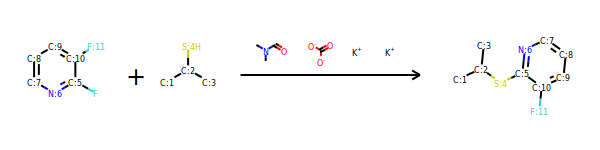

In [94]:
AllChem.ReactionFromSmarts(atom_mapped_rxn, useSmiles=True)


In [95]:
assert canonical_rxn == process_reaction(atom_mapped_rxn)


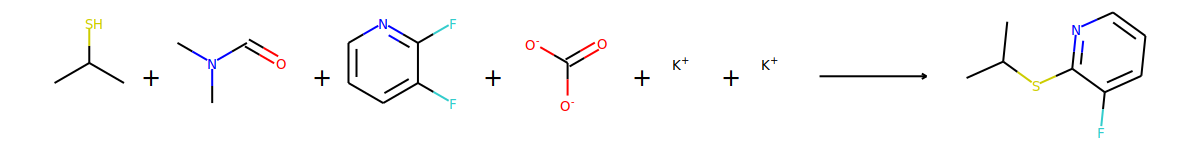

In [96]:
AllChem.ReactionFromSmarts(canonical_rxn, useSmiles=True)


In [97]:
tokenizer = get_default_tokenizer()
assert isinstance(tokenizer, SmilesTokenizer)
basic_tokenizer = RegexTokenizer()

In [98]:
assert tokenized_rxn == ' '.join(basic_tokenizer.tokenize(canonical_rxn))


In [99]:
assert len(tokenizer.vocab_list) == 591


In [100]:
import numpy 
import tmap
import faerun
import scipy
import rdkit
import rdkit.Chem
import json
import numpy as np
import pandas as pd
import tmap as tm
from tqdm import tqdm 
from faerun import Faerun
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from matplotlib.colors import LinearSegmentedColormap

In [101]:
lf = tm.LSHForest(256, 128)
mh_encoder = tm.Minhash()

In [107]:
with open('rxnclass2name.json', 'r') as f:
    rxnclass2name = json.load(f)
schneider_df = pd.read_csv('/home/crakerool/rxnfp/data/schneider50k.tsv', sep='\t', index_col=0)
ft_10k_fps = np.load('/home/crakerool/rxnfp/data/fps_ft_10k.npz')['fps']
schneider_df['rxn_category'] = schneider_df.rxn_class.apply(lambda x: '.'.join(x.split('.')[:2]))
schneider_df['rxn_superclass'] = schneider_df.rxn_class.apply(lambda x: x.split('.')[0])
schneider_df.head()



,original_rxn,rxn_class,source,rxn,split,rxn_category,rxn_superclass
0,[CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...,6.1.5,US06887874,C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...,test,6.1,6
1,O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...,7.1.1,US07056926,CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...,test,7.1,7
2,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...,1.8.5,US08492378,COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...,test,1.8,1
3,Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....,2.2.3,US08592454,CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...,train,2.2,2
4,[CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...,1.3.7,US06716851,COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...,test,1.3,1


In [103]:

mhfps = [mh_encoder.from_weight_array(fp.tolist(), method="I2CWS") for fp in tqdm(ft_10k_fps)]


100%|██████████| 50000/50000 [00:06<00:00, 7526.63it/s]


In [108]:
labels = []
# superclasses
superclasses = []

# product properties
tpsa = []
logp = []
mw = []
h_acceptors = []
h_donors = []
ring_count = []

# metals in precursors
has_Pd = []
has_Li = []
has_Mg = []
has_Al = []

for i, row in tqdm(schneider_df.iterrows(), total=len(schneider_df)):

    rxn = row["rxn"]
    labels.append(
        str(rxn)
        + "__"
        + str(rxn)
        + f"__{row['source']}"
        + f"__{rxnclass2name[row['rxn_class']]} - {row['rxn_class']}"
        + f"__{rxnclass2name[row['rxn_category']]}"
        + f"__{rxnclass2name[row['rxn_superclass']]}"
    )
    superclasses.append(int(row["rxn_superclass"]))
    
    precursors, products = rxn.split('>>')

    mol = Chem.MolFromSmiles(products)
            
    tpsa.append(Descriptors.TPSA(mol))
    logp.append(Descriptors.MolLogP(mol))
    mw.append(Descriptors.MolWt(mol))
    h_acceptors.append(Descriptors.NumHAcceptors(mol))
    h_donors.append(Descriptors.NumHDonors(mol))
    ring_count.append(Descriptors.RingCount(mol))
    
    has_Pd.append('Pd' in precursors)
    has_Li.append('Li' in precursors)
    has_Mg.append('Mg' in precursors)
    has_Al.append('Al' in precursors)
tpsa_ranked = stats.rankdata(np.array(tpsa) / max(tpsa)) / len(tpsa)
logp_ranked = stats.rankdata(np.array(logp) / max(logp)) / len(logp)
mw_ranked = stats.rankdata(np.array(mw) / max(mw)) / len(mw)
h_acceptors_ranked = stats.rankdata(np.array(h_acceptors) / max(h_acceptors)) / len(
    h_acceptors
)
h_donors_ranked = stats.rankdata(np.array(h_donors) / max(h_donors)) / len(h_donors)
ring_count_ranked = stats.rankdata(np.array(ring_count) / max(ring_count)) / len(
    ring_count
)
labels_groups, groups = Faerun.create_categories(superclasses)

labels_groups = [(label[0], f"{label[1]} - {rxnclass2name[str(label[1])]}") for label in labels_groups]

100%|██████████| 50000/50000 [00:20<00:00, 2444.66it/s]


In [109]:
# slow
lf.batch_add(mhfps)
lf.index()

# Layout
cfg = tm.LayoutConfiguration()
cfg.k = 50
cfg.kc = 50
cfg.sl_scaling_min = 1.0
cfg.sl_scaling_max = 1.0
cfg.sl_repeats = 1
cfg.sl_extra_scaling_steps = 2
cfg.placer = tm.Placer.Barycenter
cfg.merger = tm.Merger.LocalBiconnected
cfg.merger_factor = 2.0
cfg.merger_adjustment = 0
cfg.fme_iterations = 1000
cfg.sl_scaling_type = tm.ScalingType.RelativeToDesiredLength
cfg.node_size = 1 / 37
cfg.mmm_repeats = 1

# Define colormaps
set1 = plt.get_cmap("Set1").colors
rainbow = plt.get_cmap("rainbow")
colors = rainbow(np.linspace(0, 1, len(set(groups))))[:, :3].tolist()
custom_cm = LinearSegmentedColormap.from_list("my_map", colors, N=len(colors))
bin_cmap = ListedColormap([set1[8], "#5400F6"], name="bin_cmap")

# Get tree coordinates
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

In [110]:
# slow
f = Faerun(clear_color="#ffffff", coords=False, view="front",)
    
f.add_scatter(
"ReactionAtlas",
{
    "x": x, "y": y, 
    "c": [
        groups, # superclasses
        has_Pd, 
        has_Li, 
        has_Mg, 
        has_Al,
        tpsa_ranked,
        logp_ranked,
        mw_ranked,
        h_acceptors_ranked,
        h_donors_ranked,
        ring_count_ranked,
    ], 
    "labels": labels
},
shader="smoothCircle",
colormap=[
    custom_cm, 
    bin_cmap, 
    bin_cmap, 
    bin_cmap, 
    bin_cmap, 
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",
    "rainbow",

],
point_scale=2.0,
categorical=[
    True, 
    True, 
    True, 
    True, 
    True, 
    False, 
    False, 
    False, 
    False, 
    False, 
    False, 
],
has_legend=True,
legend_labels=[
    labels_groups,
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    [(0, "No"), (1, "Yes")],
    None,
    None,
    None,
    None,
    None,
    None,
],
selected_labels=["SMILES", "SMILES", "Patent ID",  "Named Reaction", "Category", "Superclass"],
series_title=[
    "Superclass", 
    "Pd", 
    "Li", 
    "Mg", 
    "Al",
    "TPSA",
    "logP",
    "Mol Weight",
    "H Acceptors",
    "H Donors",
    "Ring Count",
],
max_legend_label=[
    None,
    None,
    None,
    None,
    None,
    str(round(max(tpsa))),
    str(round(max(logp))),
    str(round(max(mw))),
    str(round(max(h_acceptors))),
    str(round(max(h_donors))),
    str(round(max(ring_count))),
],
min_legend_label=[
    None,
    None,
    None,
    None,
    None,
    str(round(min(tpsa))),
    str(round(min(logp))),
    str(round(min(mw))),
    str(round(min(h_acceptors))),
    str(round(min(h_donors))),
    str(round(min(ring_count))),
],
title_index=2,
legend_title="",
)

f.add_tree("reactiontree", {"from": s, "to": t}, point_helper="ReactionAtlas")



/home/crakerool/miniconda3/envs/mi_entorno/lib/python3.6/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


In [111]:
# hide
# slow
plot = f.plot("ft_10k_schneider_50k", template="reaction_smiles")

/home/crakerool/ft_10k_schneider_50k.html